<img src=https://raw.githubusercontent.com/sorgerlab/indra/master/doc/indra_logo.png width="500">

# Tutorial

## INDRA's conceptual architecture
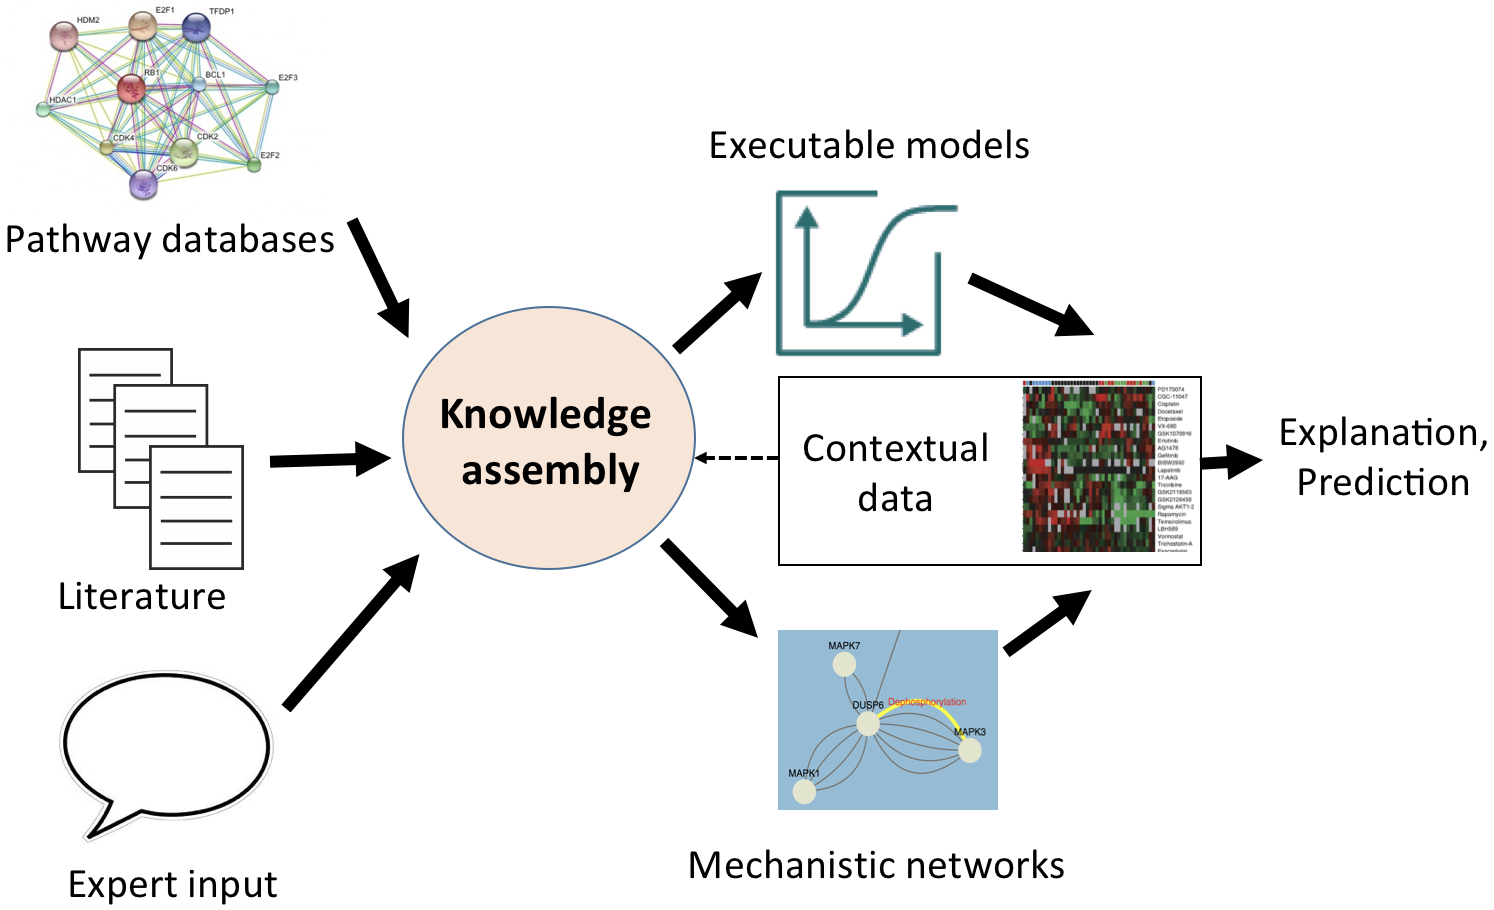

## INDRA is a Python package
- Website: http://indra.bio
- Source code, development, issues, contributions: https://github.com/sorgerlab/indra
- Documentation: http://indra.readthedocs.org

In [1]:
from util import *
import indra.sources, indra.assemblers

### INDRA knowledge input APIs / processors
- Natural language processing systems (molecular biology / general)
- Databases of molecular interactions

In [2]:
list_submodules(indra.sources)

bbn
bel
biogrid
biopax
cwms
eidos
geneways
index_cards
indra_db_rest
isi
medscan
ndex_cx
reach
signor
sofia
sparser
tees
trips


### INDRA output assemblers
- Rule-based dynamical models
- Causal network models
- Graphic formats for visualization
- English language

In [3]:
list_submodules(indra.assemblers)

cag_assembler
cx_assembler
cyjs_assembler
english_assembler
figaro_assembler
graph_assembler
index_card_assembler
kami_assembler
pybel_assembler
pysb_assembler
sbgn_assembler
sif_assembler
tsv_assembler


### INDRA's core: Statements and knowledge-level assembly
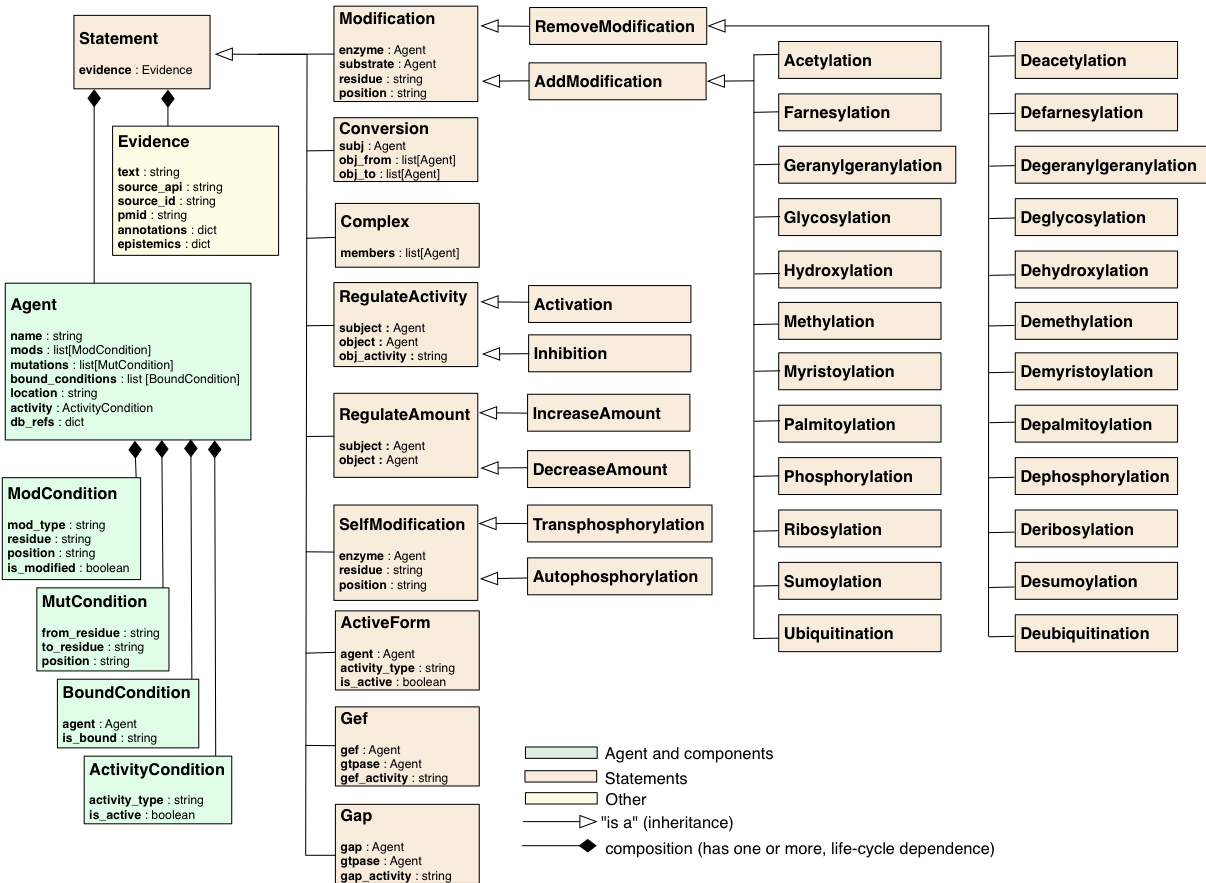

# Use case 1: Natural language modeling, rapid prototyping

<img src=http://msb.embopress.org/sites/default/files/highwire/msb/13/11.cover-source.jpg width="500">

http://msb.embopress.org/content/13/11/954

## Import reading system API

In [4]:
from indra.sources import trips

### Write a paragraph of text describing your hypothesis

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Jakstat_pathway.svg/400px-Jakstat_pathway.svg.png width="500">

In [5]:
txt = """
EPO activates JAK1, and active JAK1 phosphorylates STAT3. 
Phosphorylated STAT3 translocates to the nucleus. 
STAT3 in the nucleus is active. Active STAT3 transcribes PTP1B.
PTP1B dephosphorylates STAT3. 
Unphosphorylated STAT3 translocates from the nucleus to the cytoplasm.
"""

### Read the text with the reading system and process result into INDRA Statements

In [6]:
tp = trips.process_text(txt, save_xml_name='model_reading.xml')
#tp = trips.process_xml(open('model_reading.xml', 'r').read())

Example of the logical form from TRIPS/DRUM for one of the sentences
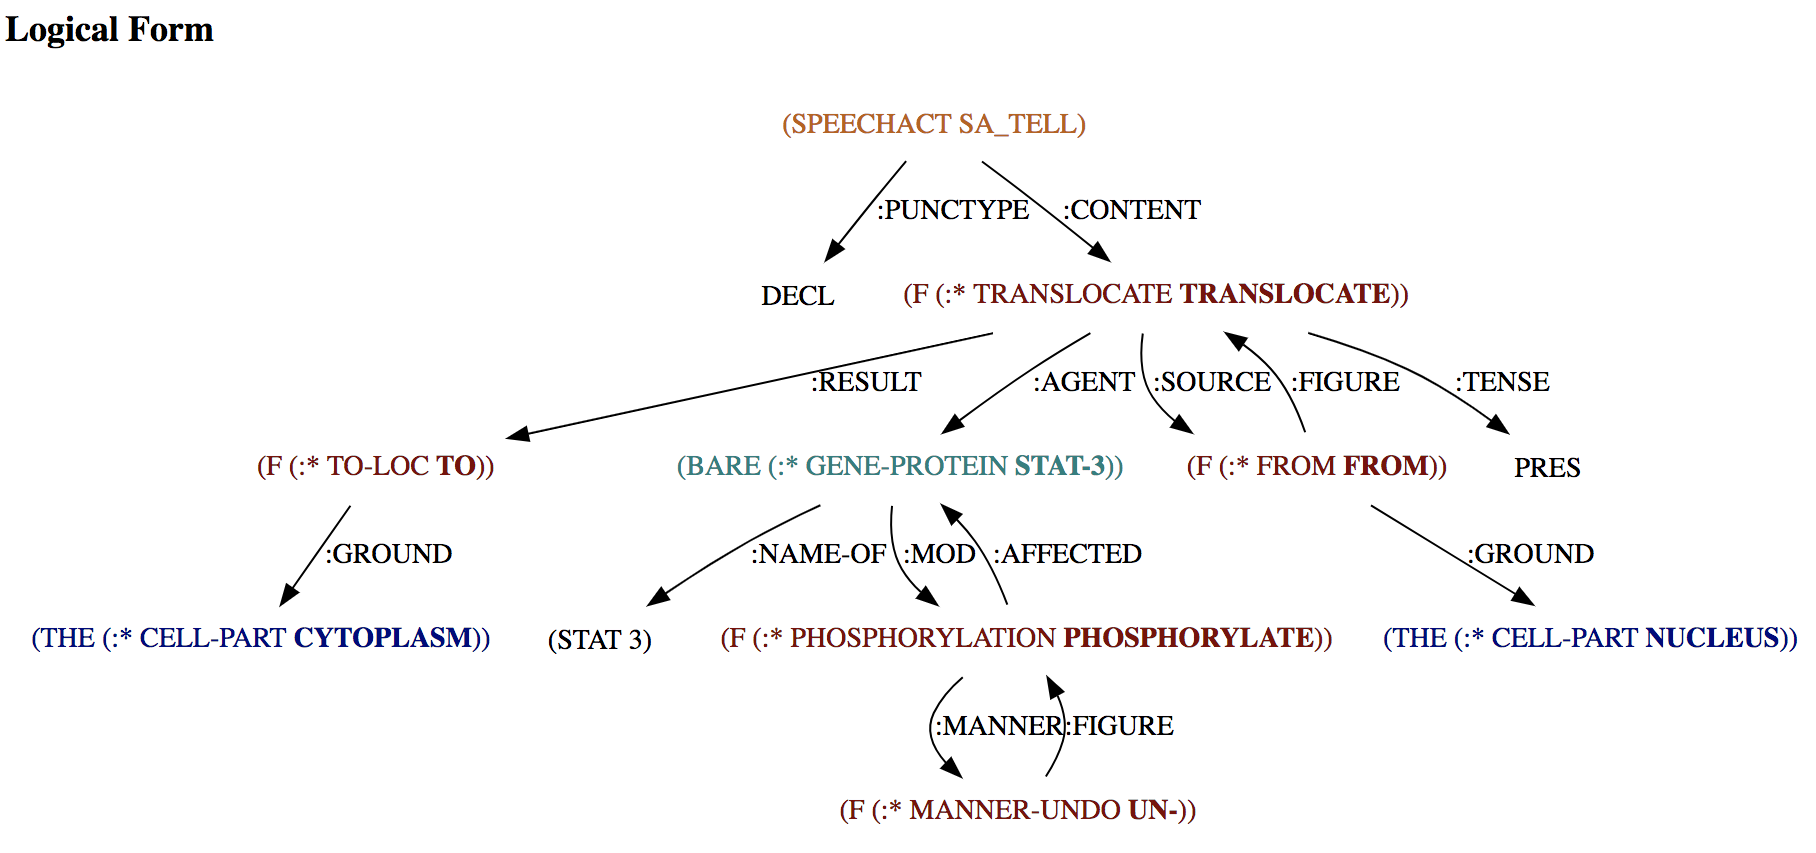

### Inspect the INDRA Statements that were extracted

In [7]:
tp.statements

[Phosphorylation(JAK1(activity), STAT3()),
 Dephosphorylation(PTPN1(), STAT3()),
 ActiveForm(STAT3(location: nucleus), activity, True),
 Activation(EPO(), JAK1()),
 Translocation(STAT3(mods: (phosphorylation)), None, nucleus),
 Translocation(STAT3(mods: (phosphorylation, False)), nucleus, cytoplasm),
 IncreaseAmount(STAT3(activity), PTPN1())]

In [8]:
print(json.dumps(tp.statements[2].to_json(), indent=1))

{
 "type": "ActiveForm",
 "agent": {
  "name": "STAT3",
  "location": "nucleus",
  "db_refs": {
   "TEXT": "STAT3",
   "HGNC": "11364",
   "UP": "P40763",
   "NCIT": "C28664"
  },
  "sbo": "http://identifiers.org/sbo/SBO:0000644"
 },
 "activity": "activity",
 "is_active": true,
 "evidence": [
  {
   "source_api": "trips",
   "text": "STAT3 in the nucleus"
  }
 ],
 "id": "84d5ef49-3748-4376-85e2-93af343be37a",
 "sbo": "http://identifiers.org/sbo/SBO:0000412"
}


### Build a rule-based mechanistic model of this knowledge
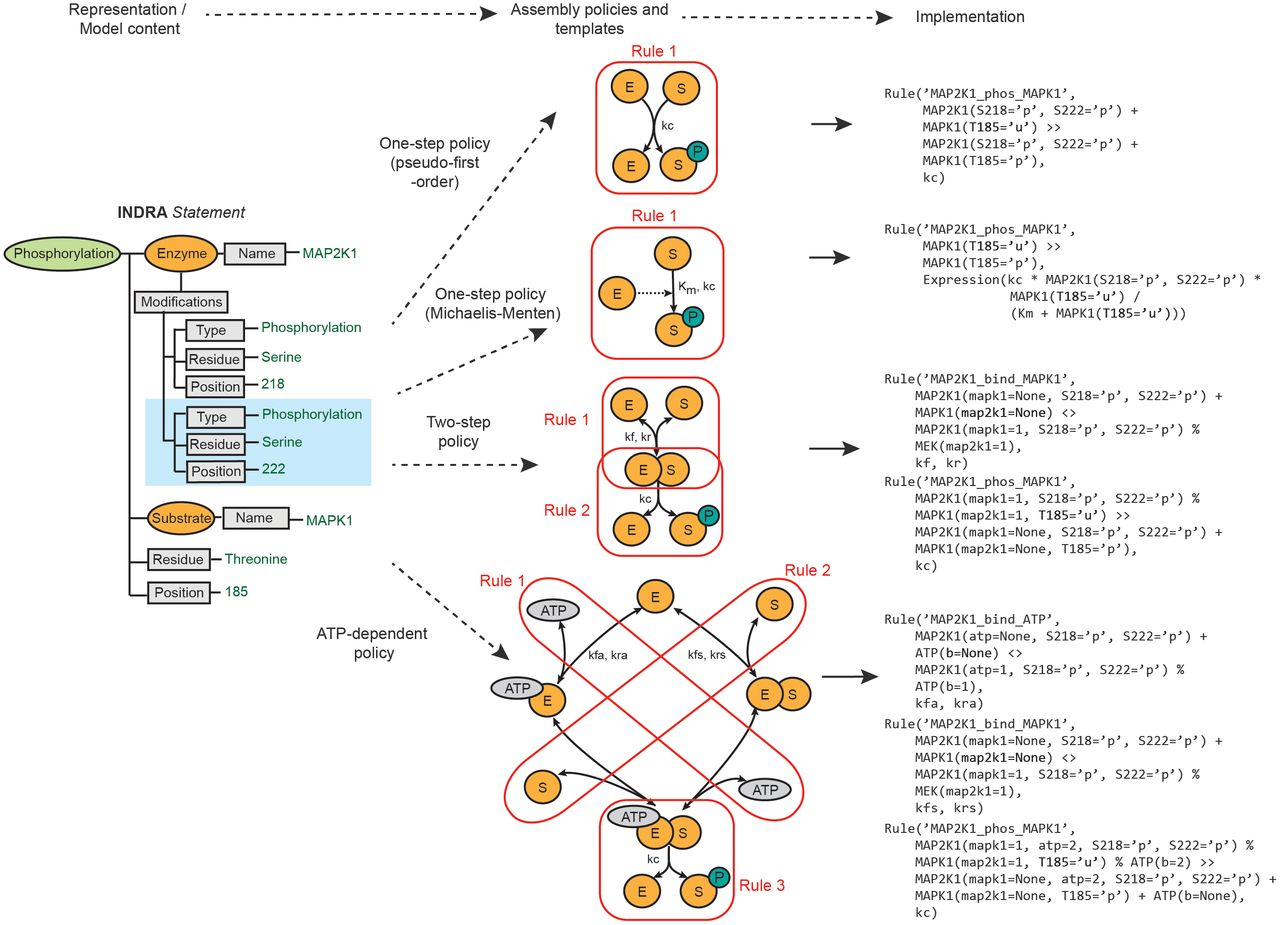

In [9]:
from indra.assemblers import PysbAssembler

In [10]:
pa = PysbAssembler()
pa.add_statements(tp.statements)
model = pa.make_model(policies='one_step')
pa.set_context('BT20_BREAST')

INFO: [2018-05-22 09:46:42] indra/pysb_assembler - Running PySB Preassembler replace activities
INFO: [2018-05-22 09:46:42] indra/pysb_assembler - Monomers set to given context
INFO: [2018-05-22 09:46:42] indra/pysb_assembler - -----------------------------
INFO: [2018-05-22 09:46:42] indra/pysb_assembler - JAK1
INFO: [2018-05-22 09:46:42] indra/pysb_assembler - STAT3
INFO: [2018-05-22 09:46:42] indra/pysb_assembler - PTPN1
INFO: [2018-05-22 09:46:42] indra/pysb_assembler - EPO


### Interactively look at the components of the model

In [11]:
model.monomers

ComponentSet([
 Monomer('JAK1', ['activity'], {'activity': ['inactive', 'active']}),
 Monomer('STAT3', ['phospho', 'loc'], {'phospho': ['u', 'p'], 'loc': ['nucleus', 'cytoplasm']}),
 Monomer('PTPN1'),
 Monomer('EPO'),
 ])

In [12]:
model.rules

ComponentSet([
 Rule('JAK1_phosphorylation_STAT3_phospho', JAK1(activity='active') + STAT3(phospho='u') >> JAK1(activity='active') + STAT3(phospho='p'), kf_js_phosphorylation_1),
 Rule('PTPN1_dephosphorylation_STAT3_phospho', PTPN1() + STAT3(phospho='p') >> PTPN1() + STAT3(phospho='u'), kf_ps_dephosphorylation_1),
 Rule('EPO_activates_JAK1_activity', EPO() + JAK1(activity='inactive') >> EPO() + JAK1(activity='active'), kf_ej_act_1),
 Rule('STAT3_phospho_translocates_cytoplasm_to_nucleus', STAT3(phospho=('p', WILD), loc='cytoplasm') >> STAT3(phospho=('p', WILD), loc='nucleus'), kf_stat3_cytoplasm_nucleus_1),
 Rule('STAT3_phospho_translocates_nucleus_to_cytoplasm', STAT3(phospho=('u', WILD), loc='nucleus') >> STAT3(phospho=('u', WILD), loc='cytoplasm'), kf_stat3_nucleus_cytoplasm_1),
 Rule('STAT3_nucleus_synthesizes_PTPN1', STAT3(loc='nucleus') + None >> STAT3(loc='nucleus') + PTPN1(), kf_sp_synth_1),
 ])

In [13]:
model.parameters

ComponentSet([
 Parameter('kf_js_phosphorylation_1', 1e-06),
 Parameter('kf_ps_dephosphorylation_1', 1e-06),
 Parameter('kf_ej_act_1', 1e-06),
 Parameter('kf_stat3_cytoplasm_nucleus_1', 1.0),
 Parameter('kf_stat3_nucleus_cytoplasm_1', 1.0),
 Parameter('kf_sp_synth_1', 0.0002),
 Parameter('JAK1_0', 272265.0),
 Parameter('STAT3_0', 349687.0),
 Parameter('PTPN1_0', 291047.0),
 Parameter('EPO_0', 12893.0),
 ])

In [14]:
model.initial_conditions

[(JAK1(activity='inactive'), Parameter('JAK1_0', 272265.0)),
 (STAT3(phospho='u', loc='cytoplasm'), Parameter('STAT3_0', 349687.0)),
 (PTPN1(), Parameter('PTPN1_0', 291047.0)),
 (EPO(), Parameter('EPO_0', 12893.0))]

### Inspect static influence structure of the model

In [15]:
im_path = draw_influence_map(model)
IFrame('model_im.png', width=800, height=600)

### Simulate dynamical model (deterministic ODEs or stochastic agent based)

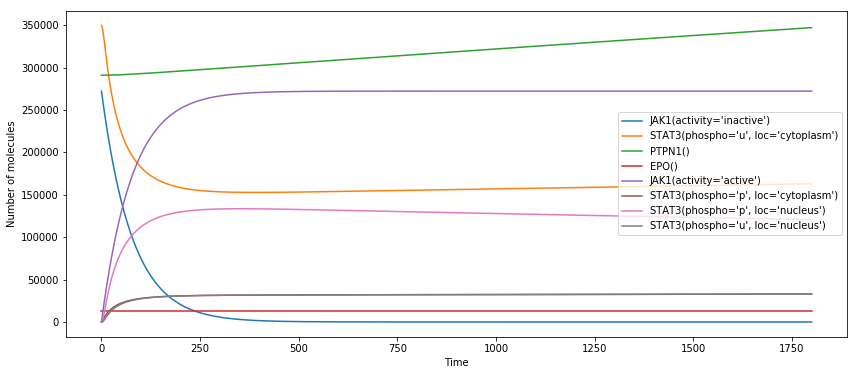

In [16]:
def sim_model(model):
    from pysb.simulator import ScipyOdeSimulator
    import numpy
    ts = numpy.linspace(0, 1800, 1000)
    sim = ScipyOdeSimulator(model, ts) # Internally uses BioNetGen to get reaction network
    sim_res = sim.run()
    plot_sim_result(model, sim_res)
sim_model(model)

### Draw mechanisms as a causal graph for visualization

In [17]:
from indra.assemblers import GraphAssembler
ga = GraphAssembler()
ga.add_statements(tp.statements)
ga.make_model()
ga.save_pdf('model_diagram.pdf')
IFrame('model_diagram.pdf', width=600, height=400)

# Reading the literature

### Download an abstract from PubMed
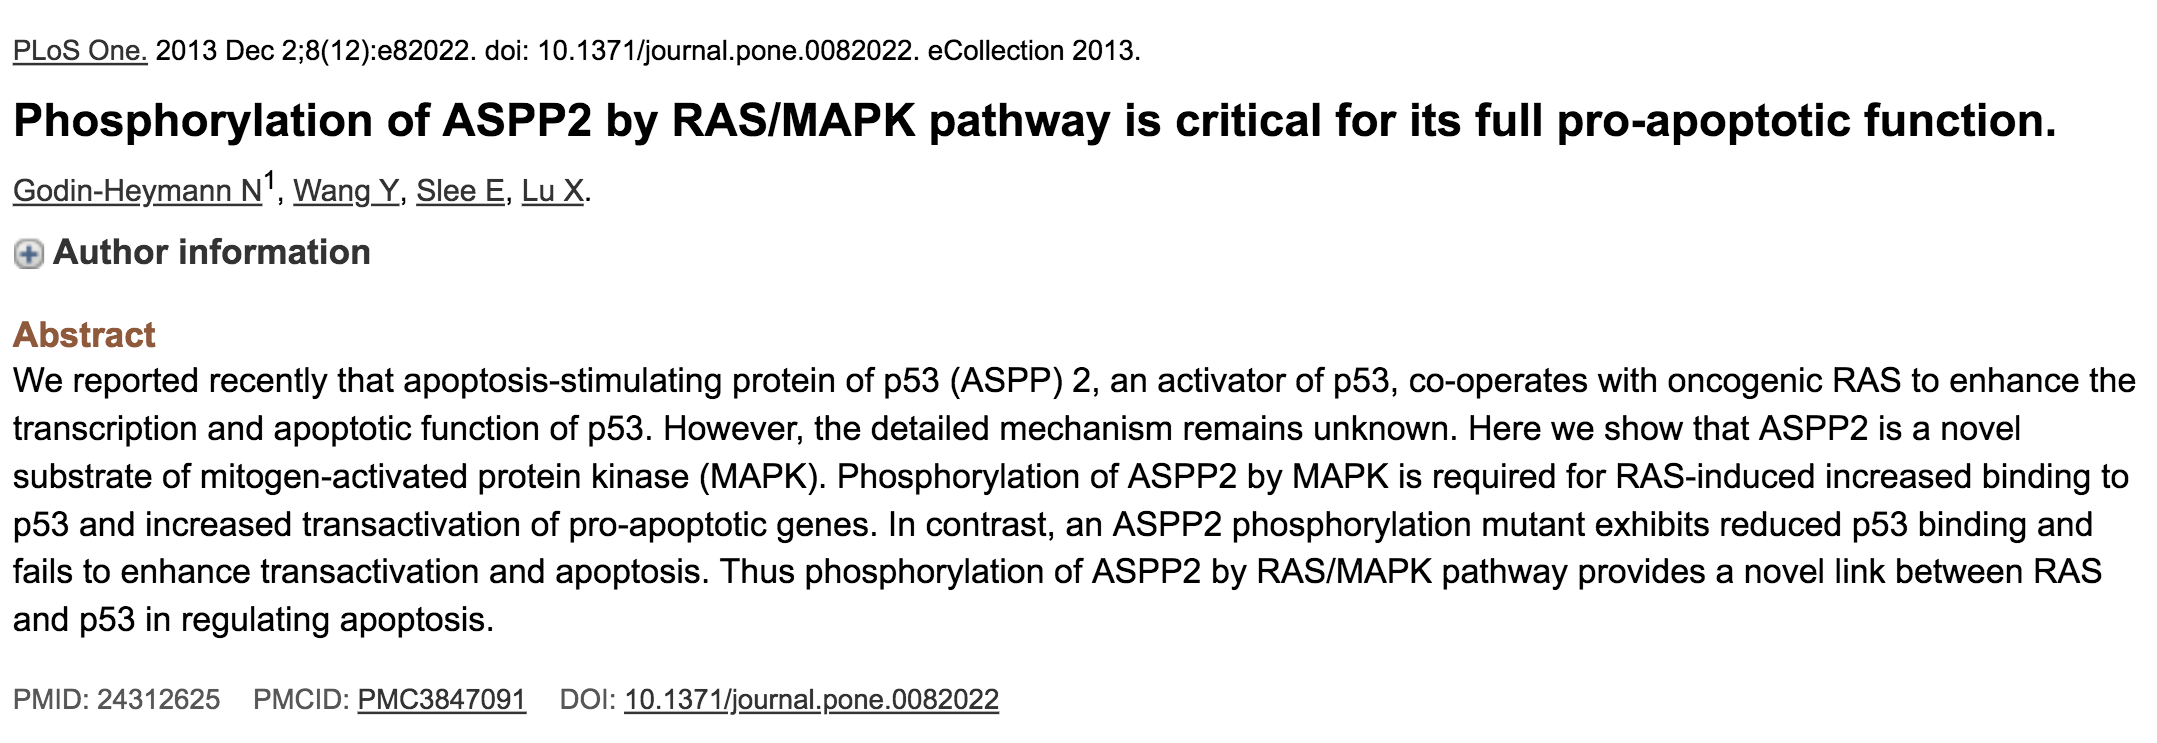

In [18]:
from indra.literature import pubmed_client
abstract = pubmed_client.get_abstract('24312625')

In [19]:
abstract

'Phosphorylation of ASPP2 by RAS/MAPK pathway is critical for its full pro-apoptotic function. We reported recently that apoptosis-stimulating protein of p53 (ASPP) 2, an activator of p53, co-operates with oncogenic RAS to enhance the transcription and apoptotic function of p53. However, the detailed mechanism remains unknown. Here we show that ASPP2 is a novel substrate of mitogen-activated protein kinase (MAPK). Phosphorylation of ASPP2 by MAPK is required for RAS-induced increased binding to p53 and increased transactivation of pro-apoptotic genes. In contrast, an ASPP2 phosphorylation mutant exhibits reduced p53 binding and fails to enhance transactivation and apoptosis. Thus phosphorylation of ASPP2 by RAS/MAPK pathway provides a novel link between RAS and p53 in regulating apoptosis. '

### Read with two reading systems, REACH and Sparser

In [20]:
from indra.sources import reach, sparser
rp = reach.process_text(abstract)
sp = sparser.process_text(abstract)

ERROR: [2018-05-22 09:46:47] indra/indra_statements - Agent missing name.
ERROR: [2018-05-22 09:46:47] indra/indra_statements - Agent missing name.


### What did the readers get?

In [21]:
rp.statements

[Phosphorylation(RAS(), TP53BP2()),
 Phosphorylation(ERK(), TP53BP2()),
 Phosphorylation(ERK(), TP53BP2()),
 Phosphorylation(ERK(), TP53BP2()),
 Phosphorylation(RAS(), TP53BP2()),
 Activation(TP53(), transcription()),
 Activation(apoptosis(), transcription()),
 Activation(TP53(), transcription()),
 Activation(TP53BP2(), apoptosis())]

In [22]:
sp.statements

[Phosphorylation(None, TP53BP2()),
 Phosphorylation(mitogen activated protein kinase(), TP53BP2()),
 Phosphorylation(None, TP53BP2()),
 Phosphorylation(None, TP53BP2())]

In [23]:
rp.statements[-1].evidence

[Evidence(reach, api8374, {'found_by': 'Positive_activation_syntax_1_verb'}, In contrast, an ASPP2 phosphorylation mutant exhibits reduced p53 binding and fails to enhance transactivation and apoptosis.)]

## Assembly at scale from multiple sources
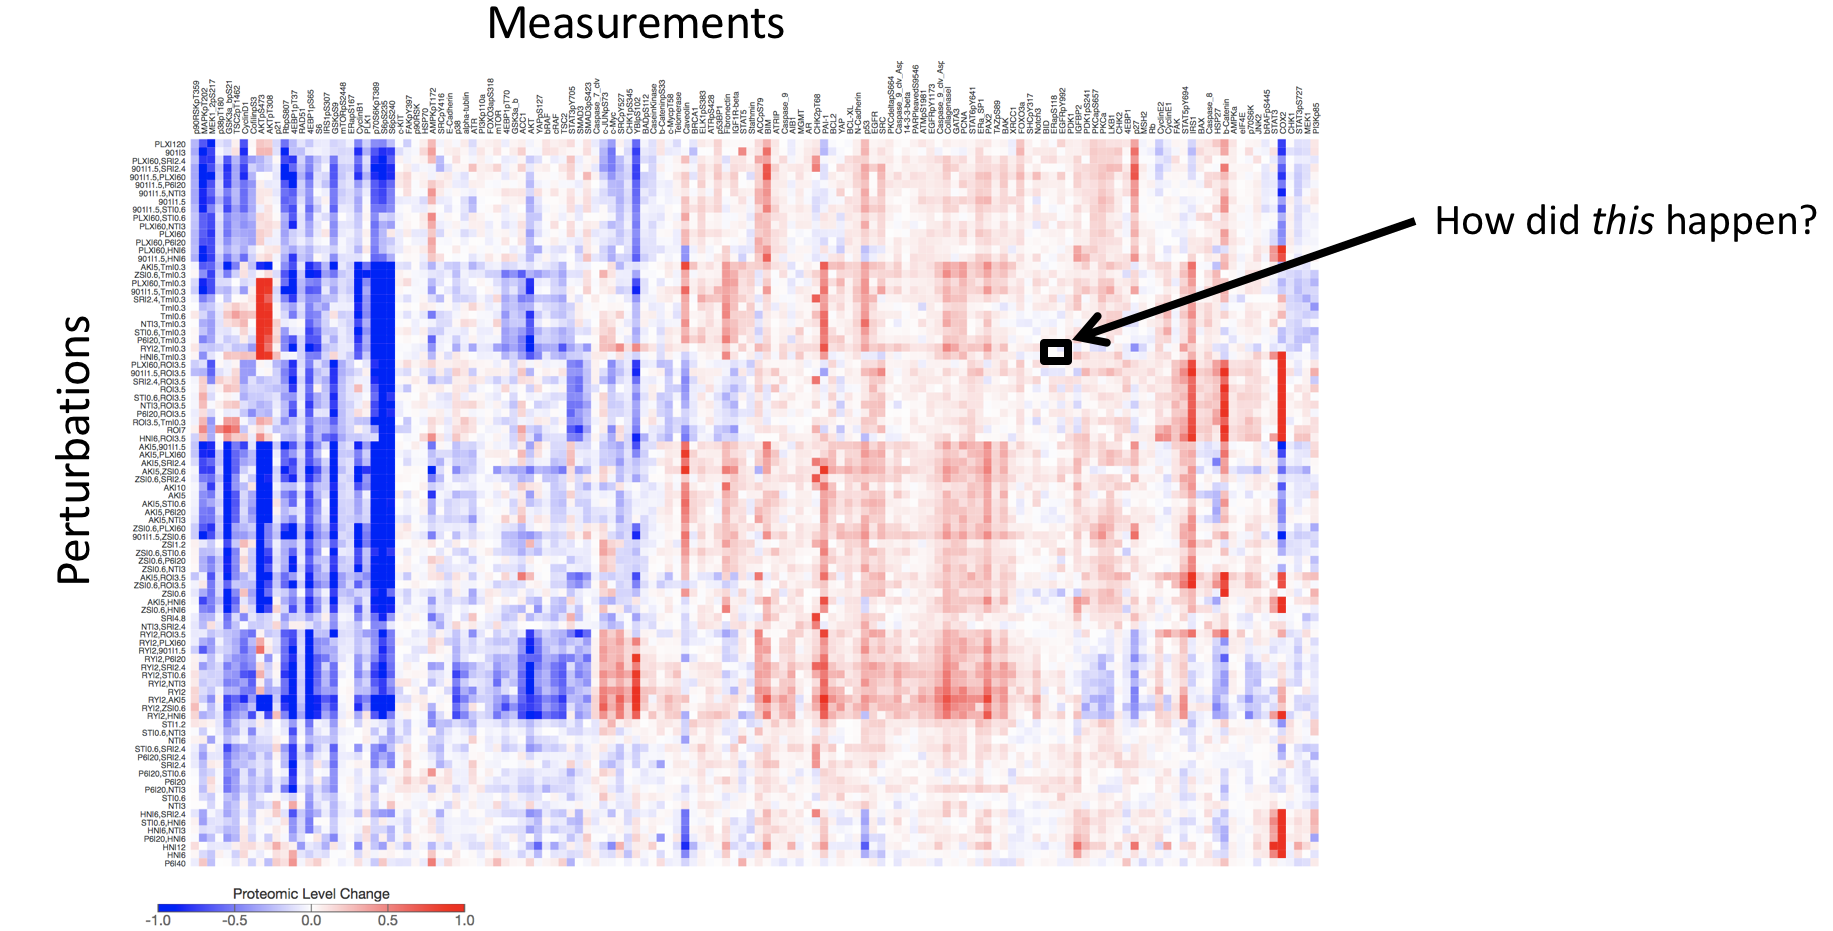

### Read a larger literature corpus
- All publications about a set of 7 proteins ~6,500 papers
- Pull in all interactions from databases and read with 2 reading systems

### Aggregate all input in the form of INDRA Statements

In [24]:
import indra.tools.assemble_corpus as ac

In [25]:
stmts = ac.load_statements('bel_stmts.pkl') + \
    ac.load_statements('biopax_stmts.pkl') + \
    ac.load_statements('reading_stmts.pkl')

INFO: [2018-05-22 09:46:47] indra/assemble_corpus - Loading bel_stmts.pkl...
INFO: [2018-05-22 09:46:48] indra/assemble_corpus - Loaded 1506 statements
INFO: [2018-05-22 09:46:48] indra/assemble_corpus - Loading biopax_stmts.pkl...
INFO: [2018-05-22 09:46:48] indra/assemble_corpus - Loaded 872 statements
INFO: [2018-05-22 09:46:48] indra/assemble_corpus - Loading reading_stmts.pkl...
INFO: [2018-05-22 09:46:50] indra/assemble_corpus - Loaded 75702 statements


### Example of an INDRA custom assembly pipeline for a use case
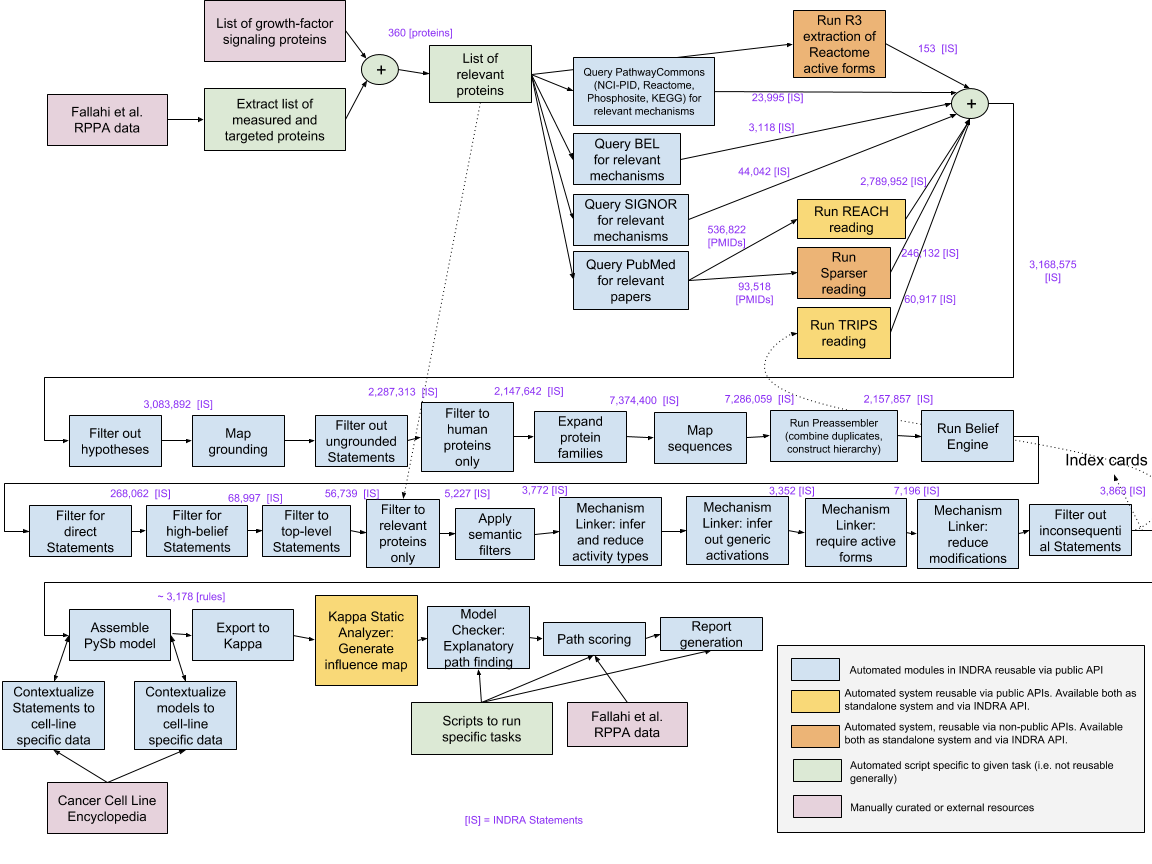

### Build up a custom assembly pipeline for this scenario

In [26]:
stmts = ac.filter_no_hypothesis(stmts)
stmts = ac.map_grounding(stmts)
stmts = ac.filter_grounded_only(stmts)
stmts = ac.filter_genes_only(stmts)
stmts = ac.filter_human_only(stmts)
stmts = ac.map_sequence(stmts)
stmts = ac.run_preassembly(stmts, return_toplevel=False)

INFO: [2018-05-22 09:46:50] indra/assemble_corpus - Filtering 78080 statements to no hypothesis...
INFO: [2018-05-22 09:46:50] indra/assemble_corpus - 76548 statements after filter...
INFO: [2018-05-22 09:46:50] indra/assemble_corpus - Mapping grounding on 76548 statements...
INFO: [2018-05-22 09:47:00] indra/grounding_mapper - 1508 statements filtered out
INFO: [2018-05-22 09:47:00] indra/assemble_corpus - Filtering 75040 statements for grounded agents...
INFO: [2018-05-22 09:47:00] indra/assemble_corpus - 63732 statements after filter...
INFO: [2018-05-22 09:47:00] indra/assemble_corpus - Filtering 63732 statements for ones containing genes only...
INFO: [2018-05-22 09:47:01] indra/assemble_corpus - 46213 statements after filter...
INFO: [2018-05-22 09:47:01] indra/assemble_corpus - Filtering 46213 statements for human genes only...
INFO: [2018-05-22 09:47:01] indra/assemble_corpus - 43524 statements after filter...
INFO: [2018-05-22 09:47:01] indra/assemble_corpus - Mapping sites on

### Generate the graph of exact and partial / hierarchical redundancies

In [27]:
from indra.preassembler import render_stmt_graph

In [28]:
stmt_graph = render_stmt_graph(stmts)
stmt_graph.draw('stmt_graph.pdf', prog='dot')

### Filter for high-belief Statements and the most specific level of resolution

In [29]:
stmts = ac.filter_belief(stmts, 0.85)
stmts = ac.filter_top_level(stmts)

INFO: [2018-05-22 09:48:14] indra/assemble_corpus - Filtering 14897 statements to above 0.850000 belief
INFO: [2018-05-22 09:48:14] indra/assemble_corpus - 7006 statements after filter...
INFO: [2018-05-22 09:48:14] indra/assemble_corpus - Filtering 7006 statements for top-level...
INFO: [2018-05-22 09:48:14] indra/assemble_corpus - 5159 statements after filter...


### Filter out indirect effects and apply some semantic filters

In [30]:
stmts = ac.filter_direct(stmts)
stmts = ac.filter_enzyme_kinase(stmts)
stmts = ac.filter_mod_nokinase(stmts)

INFO: [2018-05-22 09:48:14] indra/assemble_corpus - Filtering 5159 statements to direct ones...
INFO: [2018-05-22 09:48:14] indra/assemble_corpus - 1751 statements after filter...
INFO: [2018-05-22 09:48:14] indra/assemble_corpus - Filtering 1751 statements to remove phosphorylation by non-kinases...
INFO: [2018-05-22 09:48:14] indra/assemble_corpus - 1199 statements after filter...
INFO: [2018-05-22 09:48:14] indra/assemble_corpus - Filtering 1199 statements to remove non-phospho modifications by kinases...
INFO: [2018-05-22 09:48:14] indra/assemble_corpus - 1075 statements after filter...


### Assemble a rule-based model

In [31]:
pa = PysbAssembler()
pa.add_statements(stmts)
pa.make_model()

INFO: [2018-05-22 09:48:14] indra/pysb_assembler - Running PySB Preassembler replace activities


<Model 'None' (monomers: 688, rules: 1755, parameters: 2448, expressions: 0, compartments: 0) at 0x16f2a2470>

### Explain observations with the model
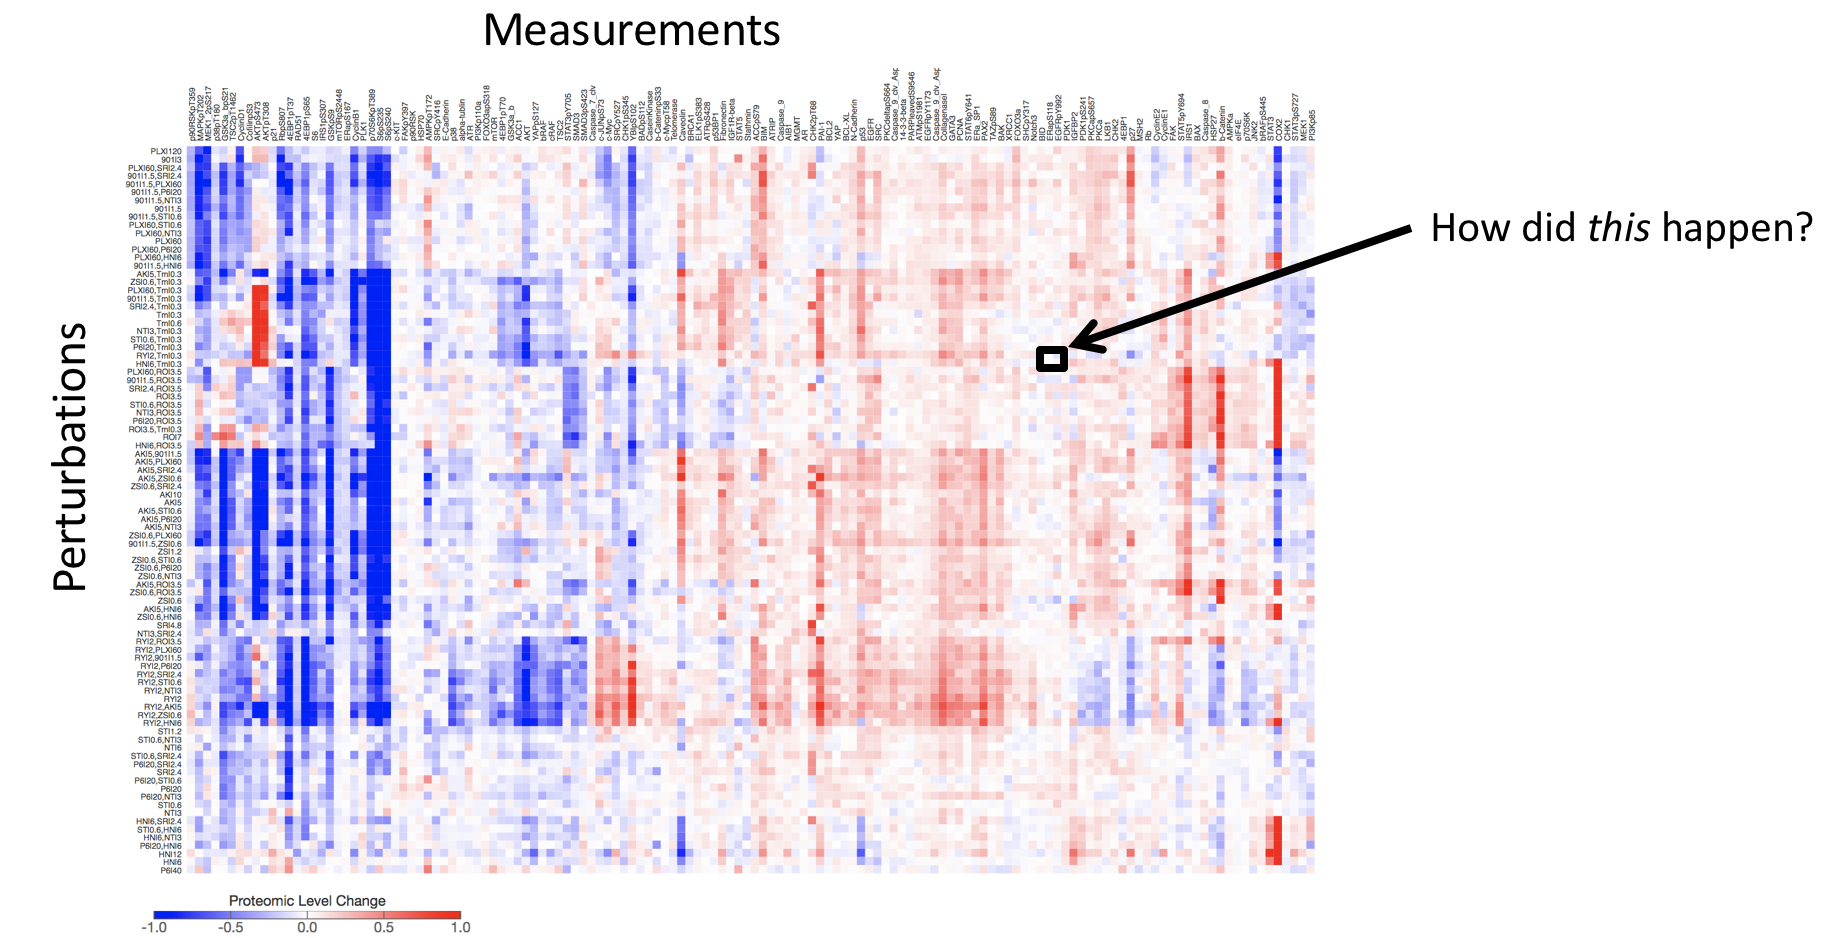

In [32]:
from indra.explanation.model_checker import ModelChecker

### Describe the observation in NL or get from real dataset

In [33]:
tp = trips.process_text('BRAF phosphorylates CDKN1B')

### Find mechanistic paths in the dynamical model's influence map

In [34]:
mc = ModelChecker(pa.model, tp.statements)
mc.prune_influence_map()
path_results = mc.check_model(max_paths=5)
paths = path_results[0][1].paths
paths

INFO: [2018-05-22 09:48:26] indra/model_checker - Generating influence map
INFO: [2018-05-22 09:48:37] indra/model_checker - Removing self loops
INFO: [2018-05-22 09:48:37] indra/model_checker - Removing self loop: ('EIF4E_EIF4E_bind', 'EIF4E_EIF4E_bind')
INFO: [2018-05-22 09:48:37] indra/model_checker - Removing self loop: ('EIF4E_EIF4E_dissociate', 'EIF4E_EIF4E_dissociate')
INFO: [2018-05-22 09:48:37] indra/model_checker - Removing self loop: ('RELA_RELA_bind', 'RELA_RELA_bind')
INFO: [2018-05-22 09:48:37] indra/model_checker - Removing self loop: ('RELA_RELA_dissociate', 'RELA_RELA_dissociate')
INFO: [2018-05-22 09:48:37] indra/model_checker - Removing self loop: ('S100A4_S100A4_bind', 'S100A4_S100A4_bind')
INFO: [2018-05-22 09:48:37] indra/model_checker - Removing self loop: ('S100A4_S100A4_dissociate', 'S100A4_S100A4_dissociate')
INFO: [2018-05-22 09:48:37] indra/model_checker - Removing self loop: ('RAF1_phosphoT491_phosphoS338_phosphoS494_phosphoS621_phosphoY341_phosphorylation_

[(('BRAF_phosphorylation_MAPK1_T185', 1),
  ('MAPK1_phosphoT185_phosphoY187_phosphorylation_CDKN1B_T187', 1),
  ('CDKN1B_T187_p_obs', 1)),
 (('BRAF_phosphorylation_MAPK1_Y187', 1),
  ('MAPK1_phosphoT185_phosphoY187_phosphorylation_CDKN1B_T187', 1),
  ('CDKN1B_T187_p_obs', 1)),
 (('BRAF_phosphorylation_MAPK1_T185', 1),
  ('MAPK1_phosphoT185_phosphorylation_CDKN1B_T187', 1),
  ('CDKN1B_T187_p_obs', 1)),
 (('BRAF_phosphorylation_MAPK1_Y187', 1),
  ('MAPK1_phosphoY187_phosphorylation_CDKN1B_T187', 1),
  ('CDKN1B_T187_p_obs', 1)),
 (('BRAF_phosphoS579_phosphorylation_MAP2K1_S218', 1),
  ('MAP2K1_phosphoS222_phosphoS218_phosphorylation_MAPK1_T185', 1),
  ('MAPK1_phosphoT185_phosphoY187_phosphorylation_CDKN1B_T187', 1),
  ('CDKN1B_T187_p_obs', 1))]

### Report a path in English

In [35]:
from indra.explanation.reporting import stmts_from_path
from indra.assemblers import EnglishAssembler
path_stmts = stmts_from_path(paths[-1], pa.model, stmts)
print(EnglishAssembler(path_stmts).make_model())

BRAF phosphorylated on S579 phosphorylates MAP2K1 on S218. MAP2K1 phosphorylated on S222 and S218 phosphorylates MAPK1 on T185. Active MAPK1 phosphorylates CDKN1B on T187.


In [36]:
for stmt in stmts:
    sources = set([e.source_api for e in stmt.evidence])
    if len(sources) >= 3:
        print(stmt)
        break

Phosphorylation(MAPK7(), RPS6KA3())


In [37]:
stmt.evidence

[Evidence(reach, 16626623, {'found_by': 'Phosphorylation_syntax_1a_verb'}, In vitro active ERK5 also phosphorylated RSK2 that had been immunoprecipitated from transfected cells using an anti-HA antibody (B).),
 Evidence(reach, 16626623, {'found_by': 'Phosphorylation_syntax_1a_noun'}, Phosphorylation of RSK2 by ERK5 in vitro increased its activity towards GST-S6 as much as 8-fold (C and E).),
 Evidence(biopax, None, {'source_sub_id': 'panther'}, None),
 Evidence(sparser, PMC_171, {}, In vitro active ERK5 also phosphorylated RSK2 that had been immunoprecipitated from transfected cells using an anti-HA antibody (B).)]

## Some other applications

### Autonomous, self-updating model of a pathway
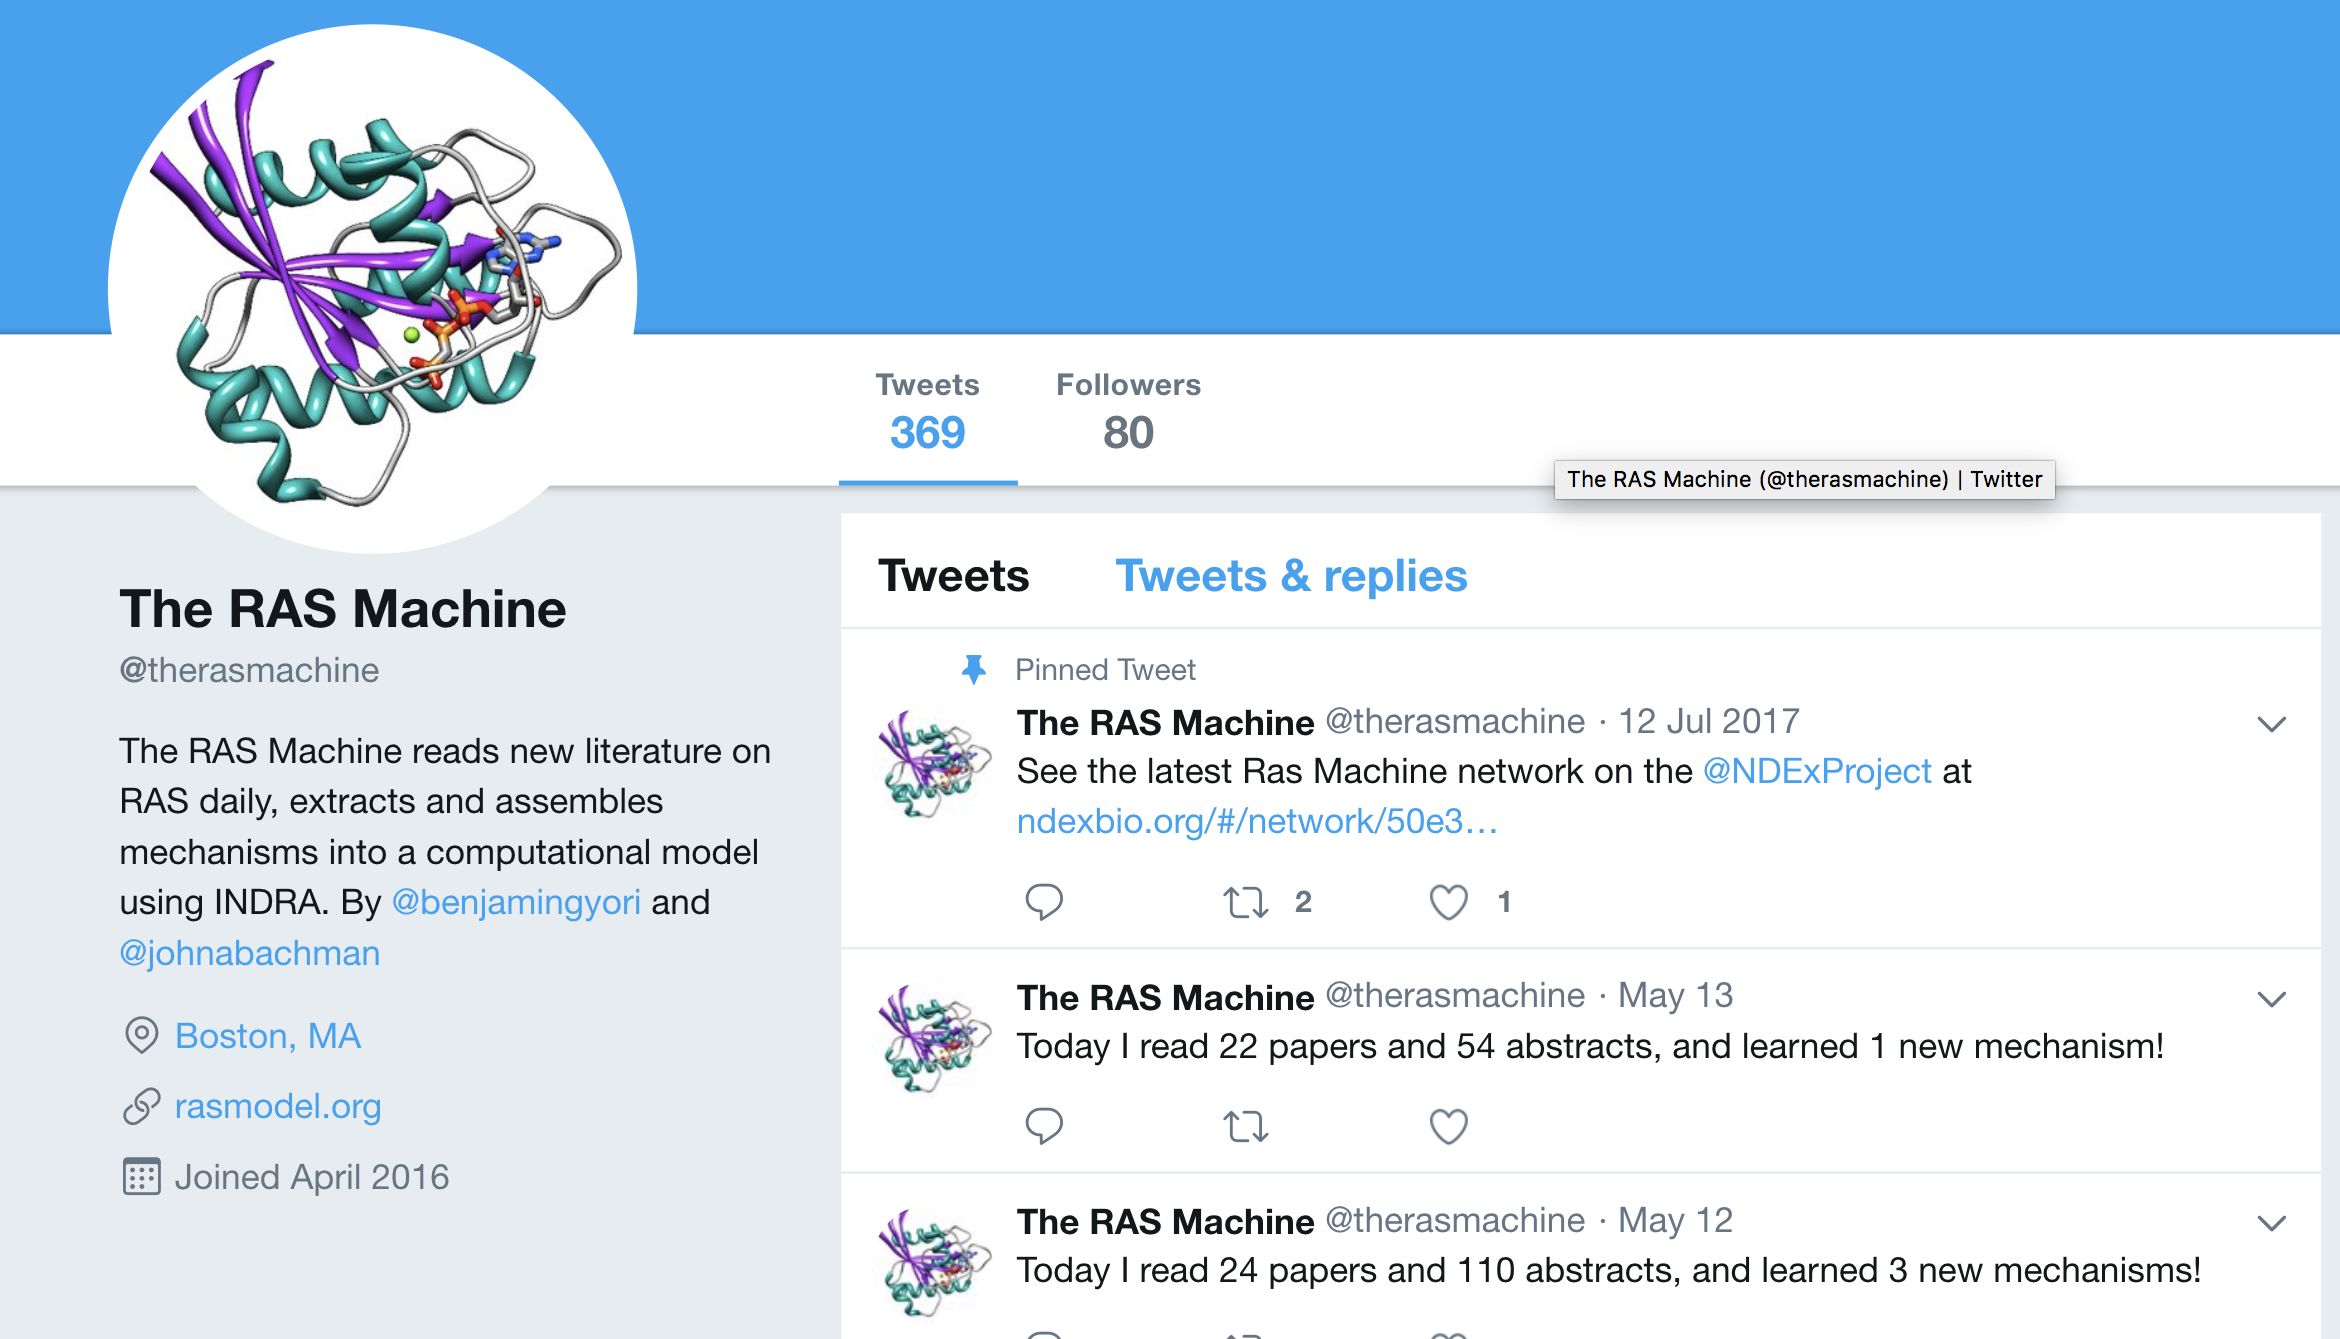
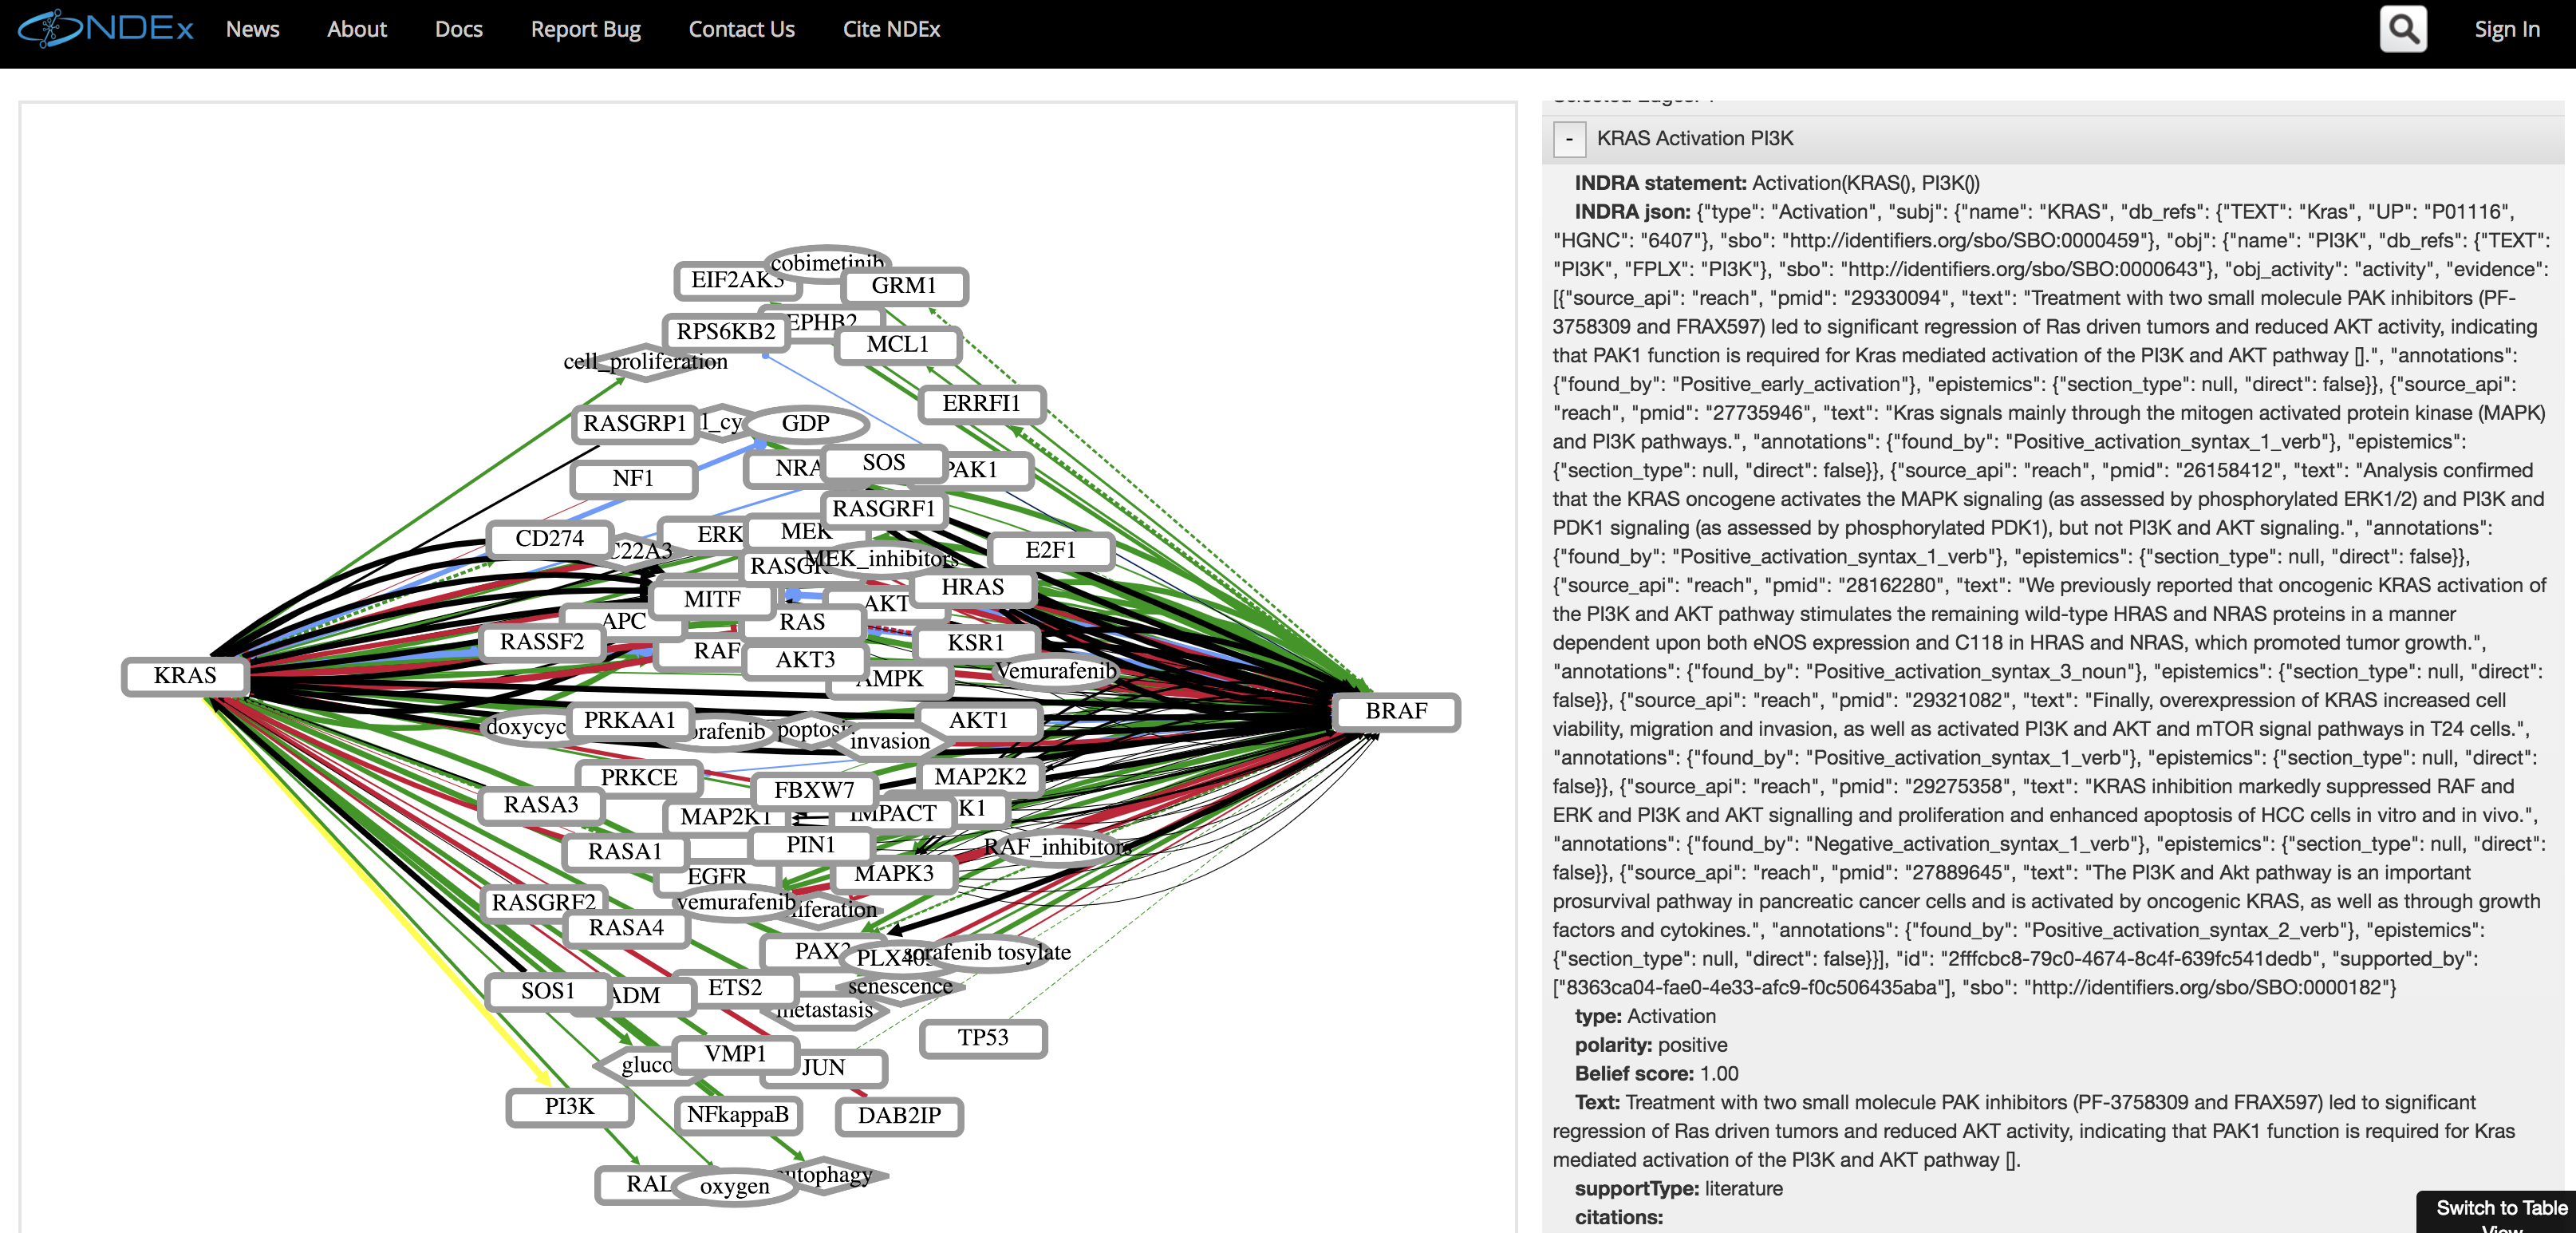

### Component of a human-machine dialogue system
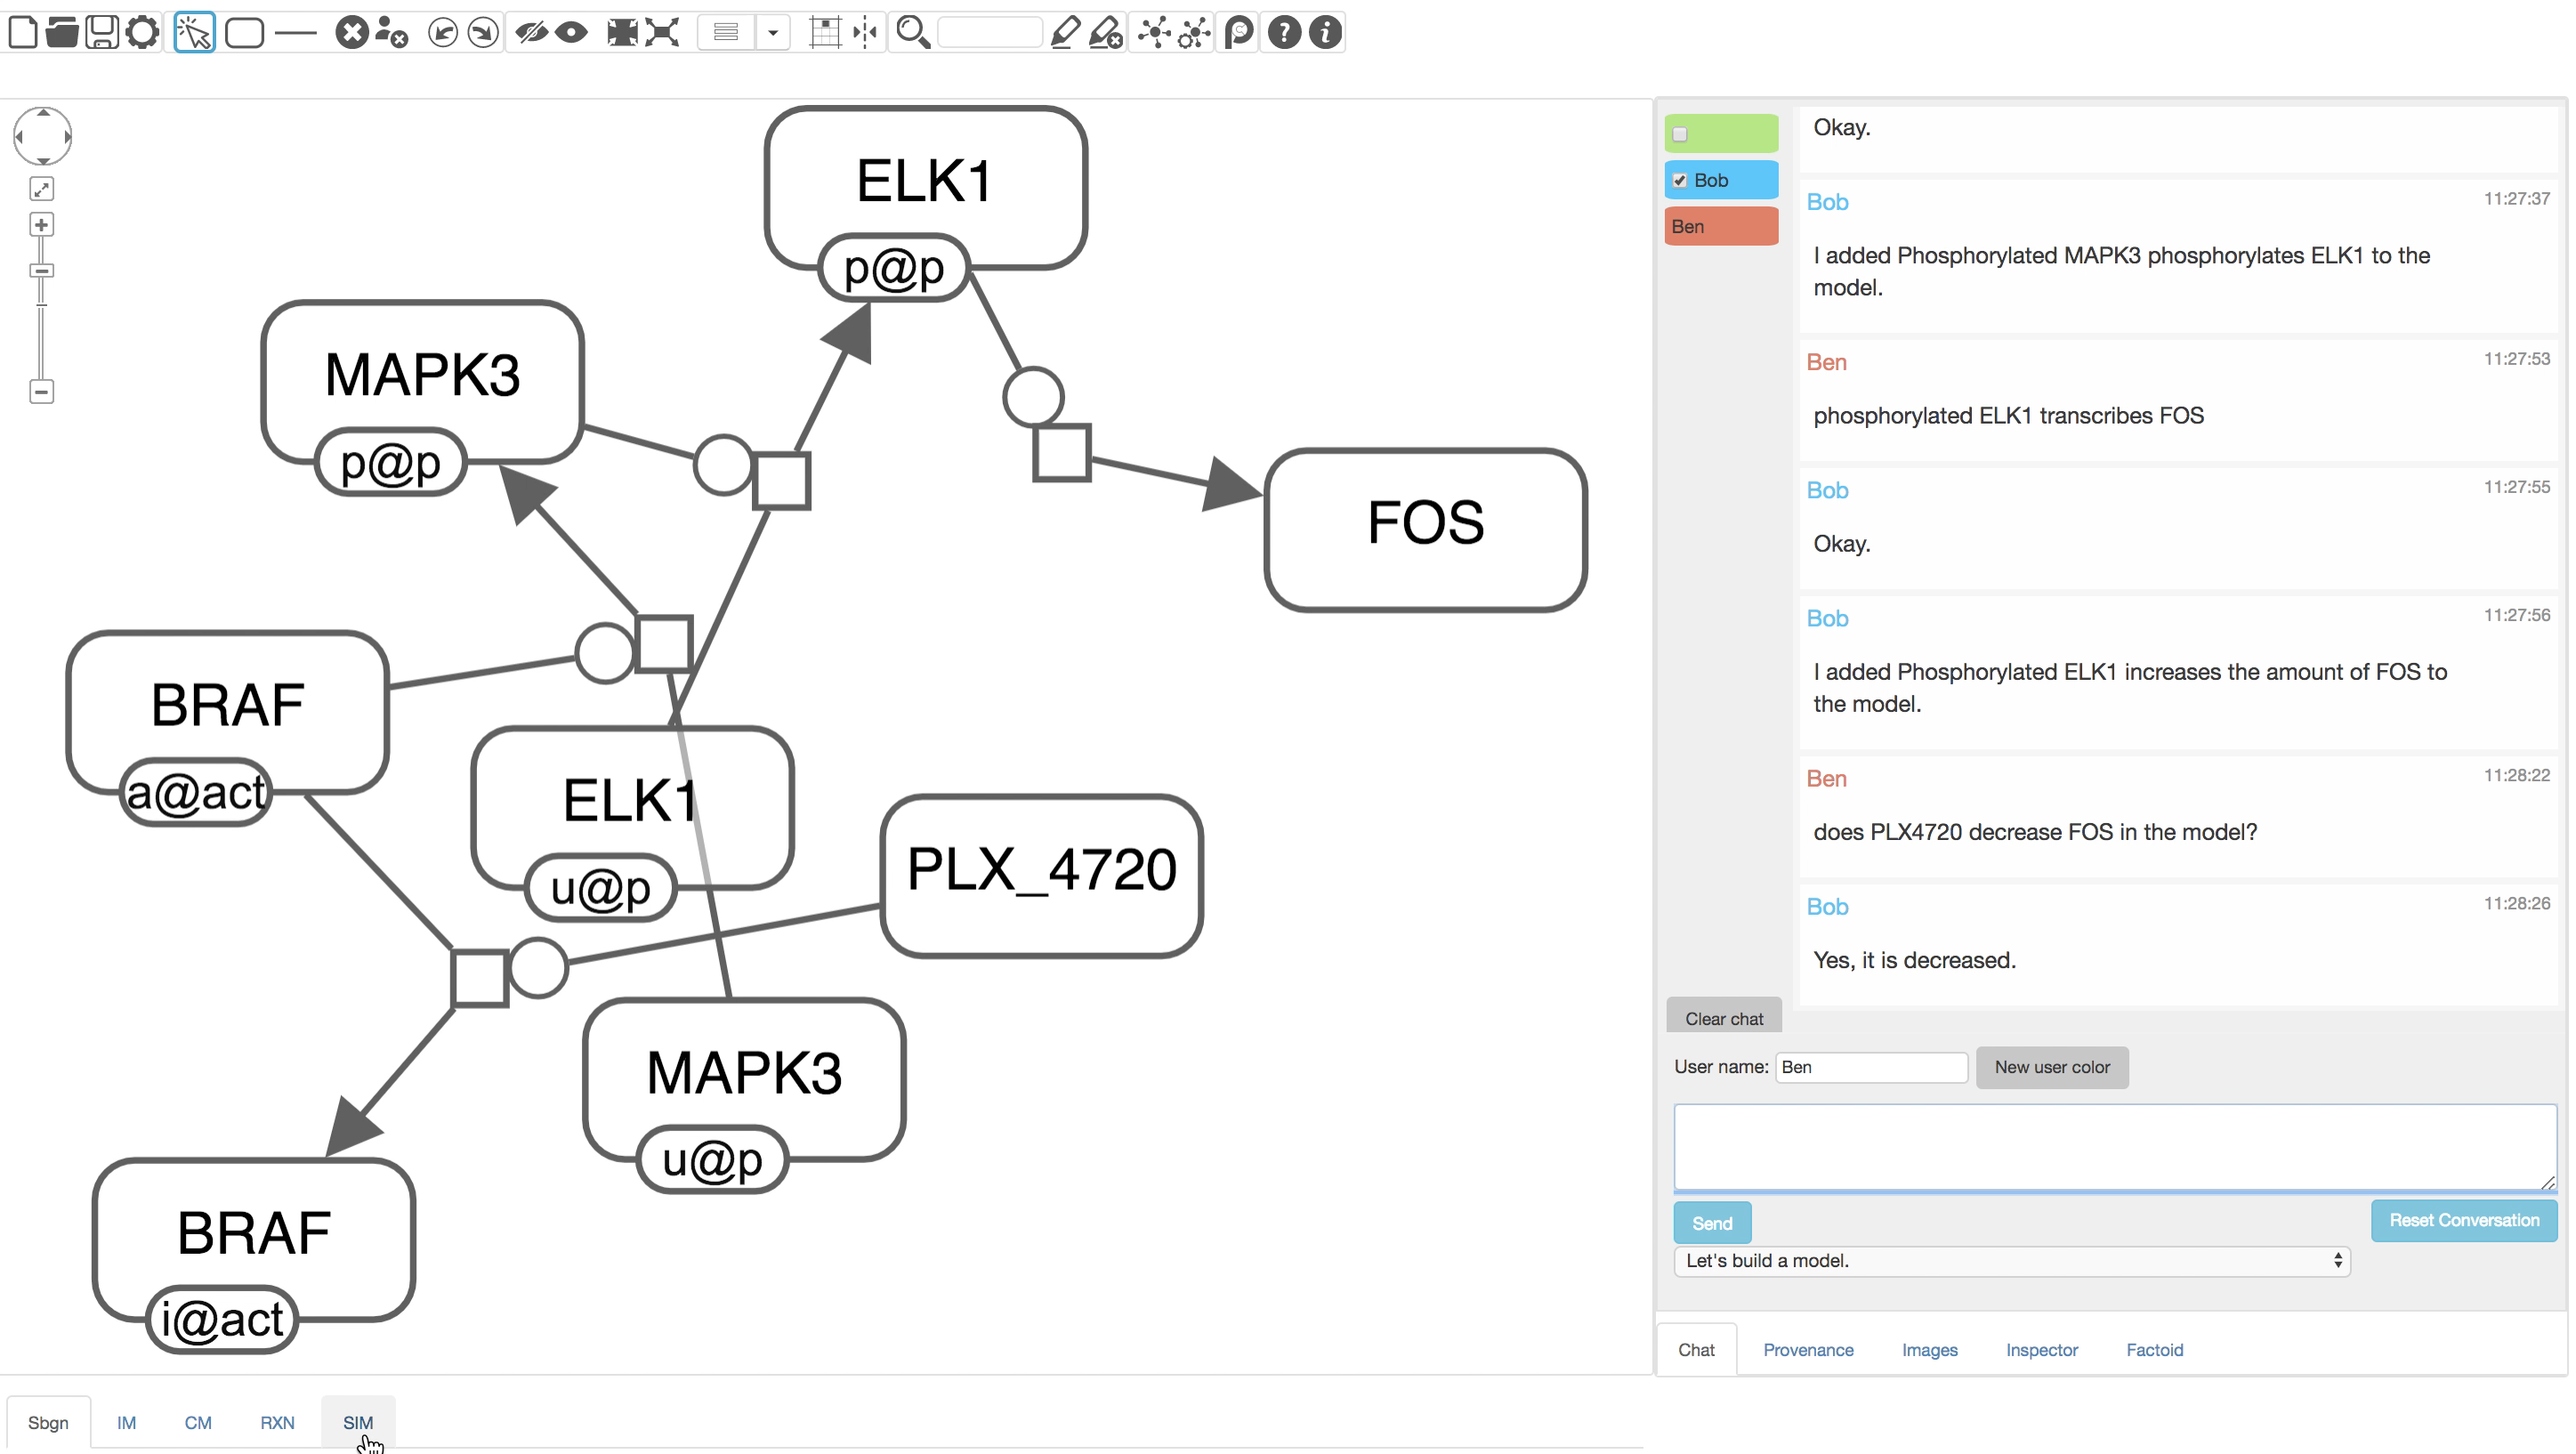
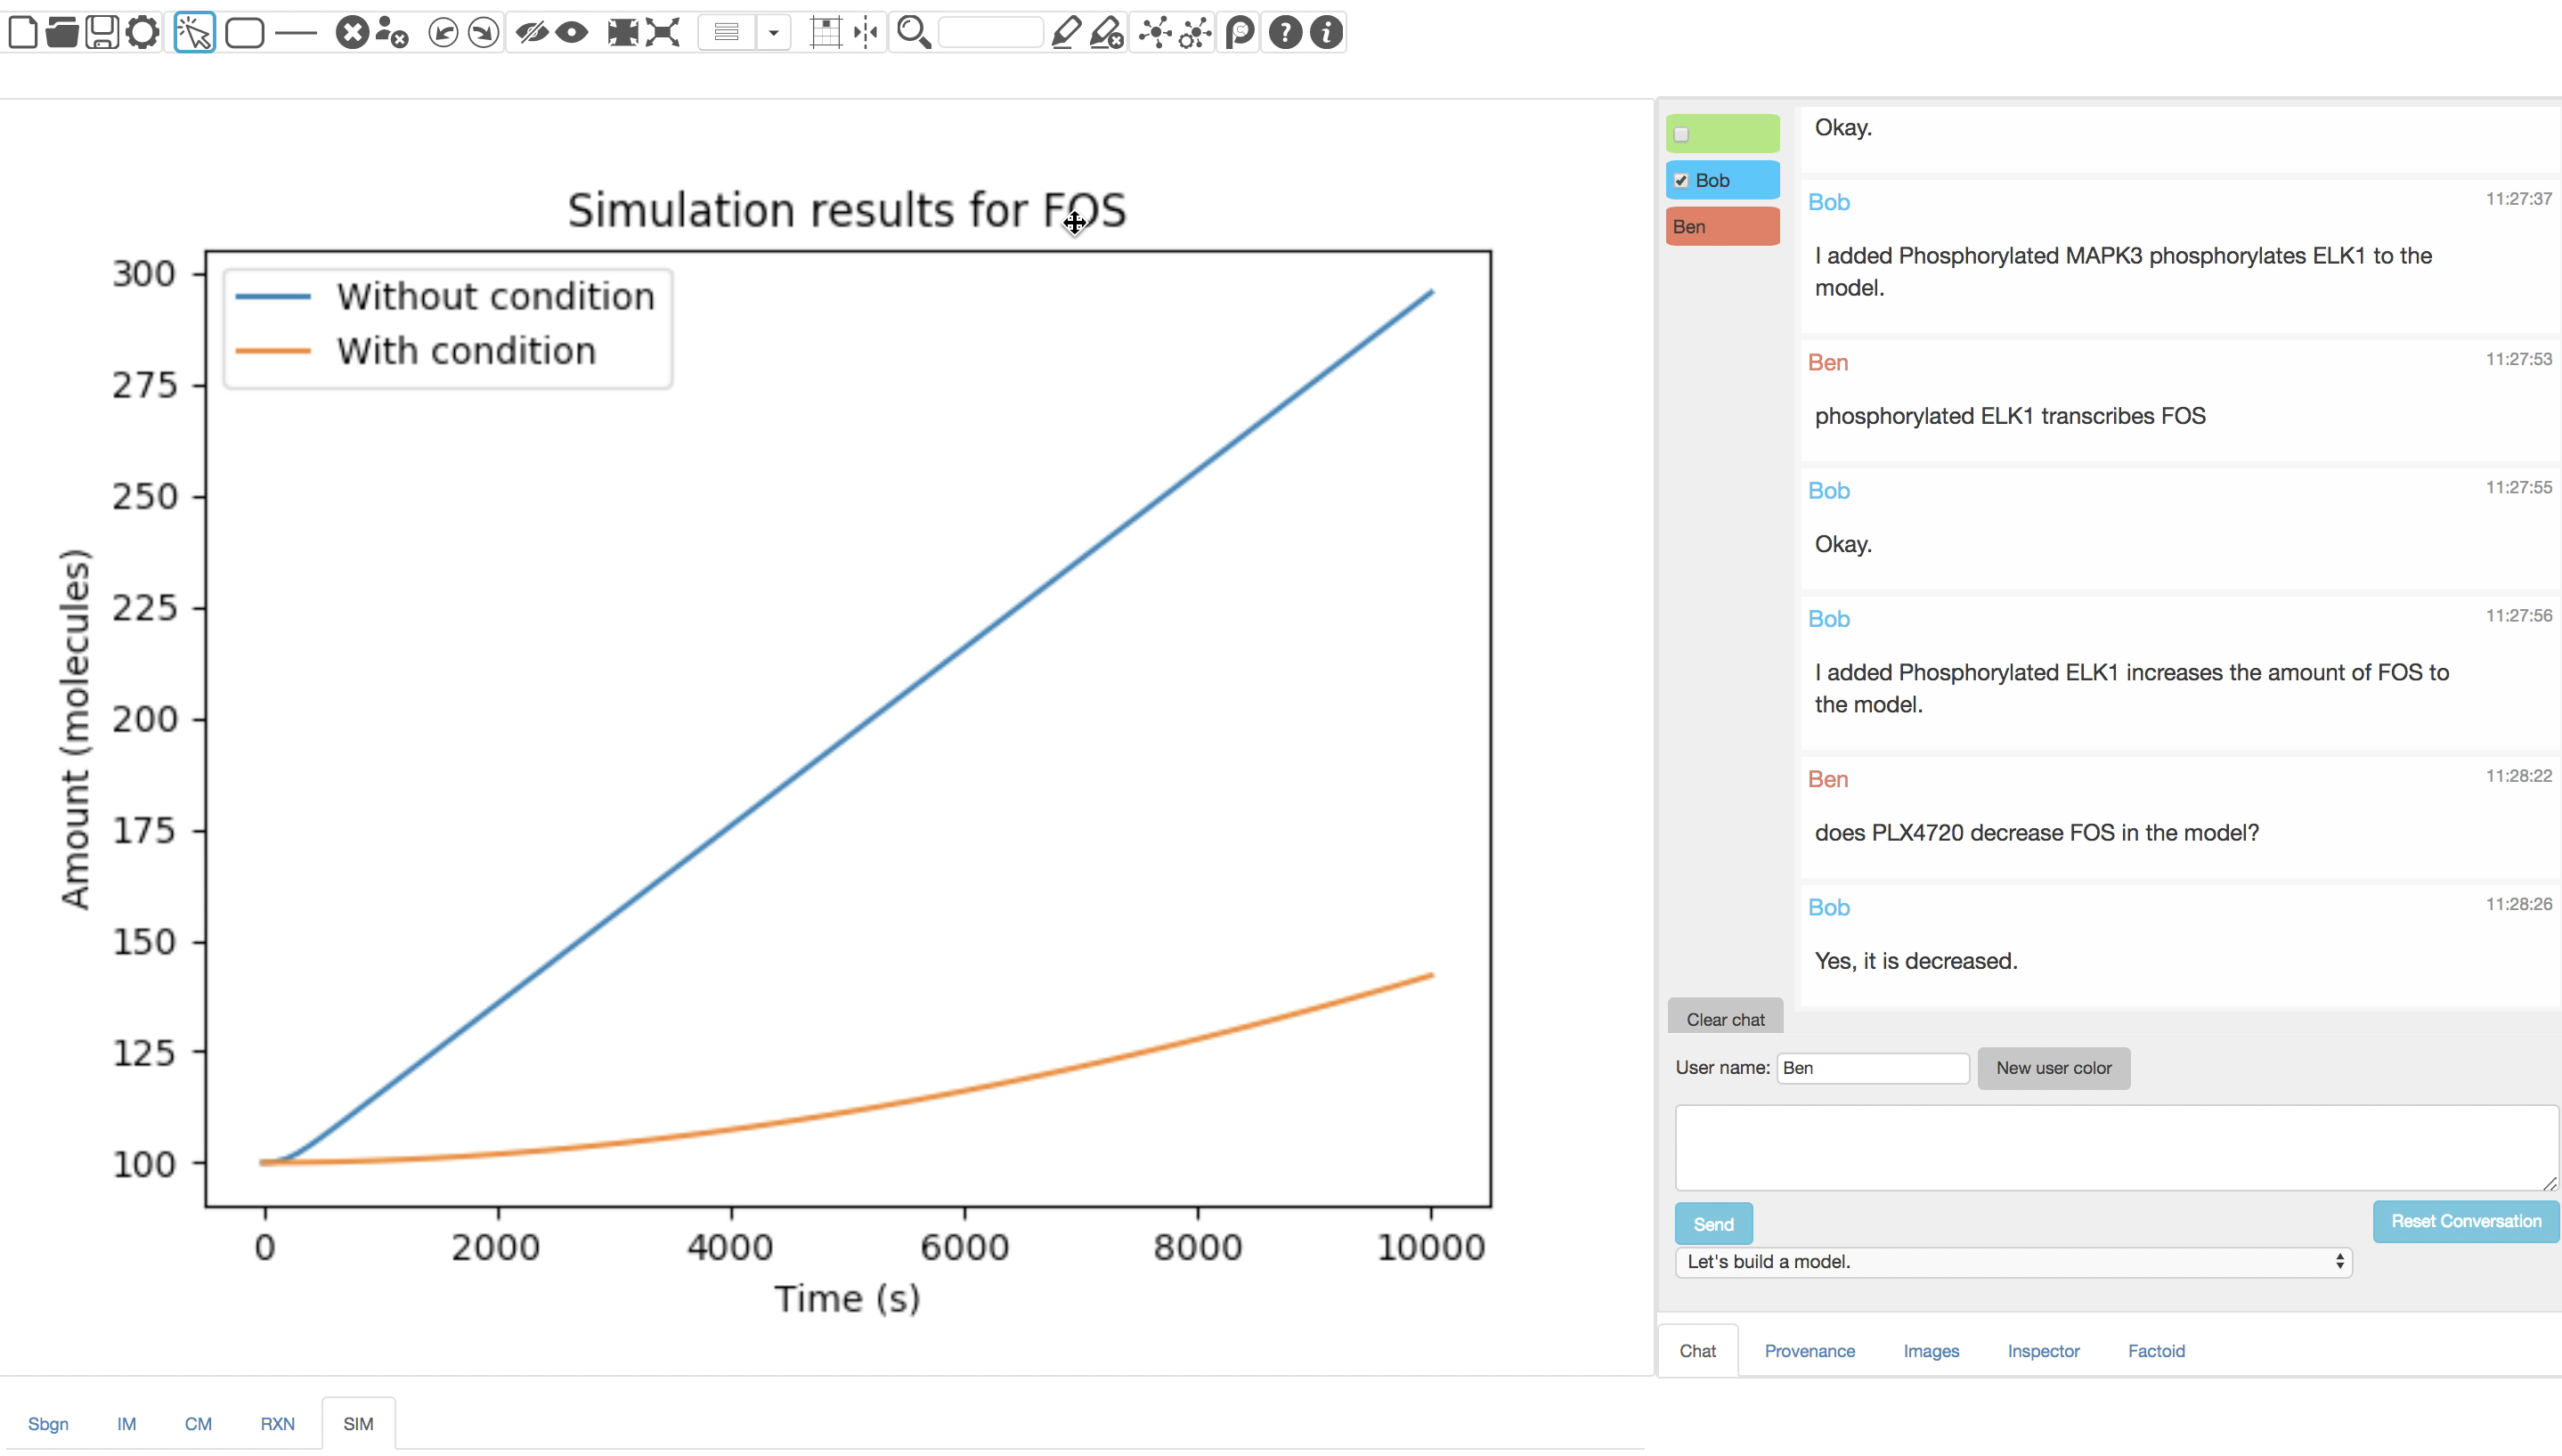

# Making models in a domain-general setting
- Input APIs and processors for generalized reading systems (Eidos, CWMS, etc.)
- Any curated / learned ontology e.g.
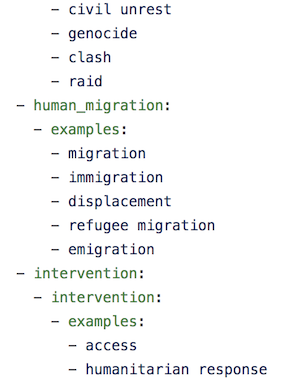

In [38]:
from indra.sources import eidos

In [39]:
txt = """
Food insecurity levels are extremely alarming throughout the country due to conflict, 
a collapsing economy, low cereal production, poor rainfall in southeastern areas, and 
the exhaustion of coping capacities after several years of crisis. In Eastern Equatoria – 
one of the drought-hit areas – the latest food security and nutrition assessments in 
November 2016 revealed that households experiencing poor food consumption nearly 
doubled from 19 to 37 percent when compared with the same time in 2015. 
Rainfall deficits were widely reported in the area, with 93 percent of 
households indicating this was a major shock during the last agricultural 
season, impacting pasture and water availability and local food production. 
Climatic forecasting indicates these areas are likely to experience depressed 
rainfall between March to May 2017."""
#ep = eidos.process_text(txt)
ep = eidos.process_json_ld_file('CAG1.json')

In [40]:
ep.statements

[Influence(shock(), pasture()),
 Influence(conflict(), Food insecurity()),
 Influence(shock(), water()),
 Influence(economy(negative), Food insecurity()),
 Influence(rainfall(negative), Food insecurity()),
 Influence(shock(), food production()),
 Influence(cereal production(negative), Food insecurity())]

In [41]:
from indra.assemblers import CAGAssembler
ca = CAGAssembler(ep.statements)
ca.make_model()
from IPython.core.display import Javascript
Javascript(ca.generate_jupyter_js())

<IPython.core.display.Javascript object>

In [42]:
ep.statements[1].subj.db_refs

{'EIDOS': [('UN/events/human/conflict/examples', 0.8424779277137565),
  ('UN/events/human/intervention/intervention/examples', 0.578830287706582),
  ('UN/entities/human/government/government_actions/examples',
   0.5698149455773452),
  ('UN/entities/GPE/examples', 0.5582304834451738),
  ('UN/events/crisis/examples', 0.5124510124752975),
  ('UN/entities/human/government/government_entity/examples',
   0.4985052191944197),
  ('UN/events/human/human_migration/examples', 0.4809195217182326),
  ('UN/entities/human/communities/examples', 0.48044607716068743),
  ('UN/entities/human/financial/economic/poverty/examples',
   0.47304899166174513),
  ('UN/events/human/famine/examples', 0.45036023380926865)],
 'TEXT': 'conflict'}

### Knowledge-assembly example from larger corpus
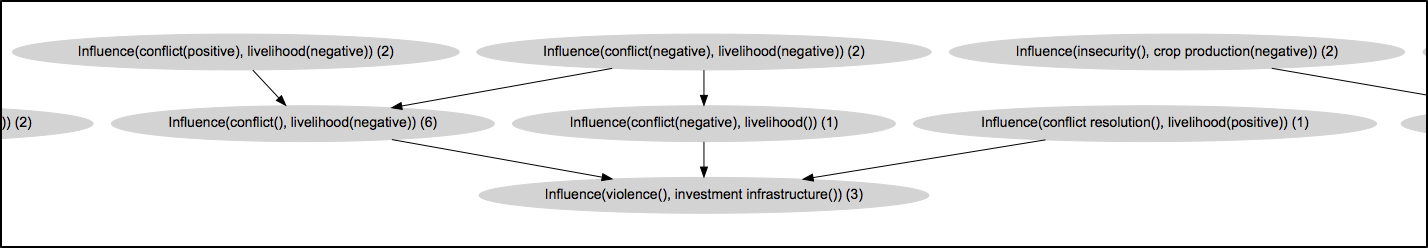